In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys

sys.path.append(str(Path("../../../").resolve()))


import numpy as np
import matplotlib.pyplot as plt
import torch
from ball_model import EXPERIMENT_DIR
from ball_model.data import get_data, iter_traj
from ball_model.data.rotations import build_aug_rot_mat
from ball_model.data.motors import actuation_to_rpm
from ball_model.filter.ekf.ekf_cell import EkfFilterCell
from ball_model.filter.filter_cell import load_filter_cell_from_run
from scipy.spatial.transform import Rotation

from ball_model import EXPERIMENT_DIR

from ball_model.utils.plotting import MplUtils

MplUtils.set_style(plt, "thesis")
%matplotlib inline

In [2]:
run_name = "model_ekf_g_lp7aug_sialways_s1"
run_dir = EXPERIMENT_DIR.joinpath(run_name)
checkpoint_step = 10_000
device = "cpu"
filter_cell = load_filter_cell_from_run(run_dir, checkpoint_step, device)

In [3]:
motor_settings = []
W_nn = []

# Check spins on test split of the default launcher orientation
for traj_name in iter_traj("lp7", "test"):
    traj = get_data(traj_name)
    # Last three elements in `side_info` are motor actuations
    motor_settings.append(traj.side_info[-3:])

# Predict spints from motor settings
motor_settings_np = np.array(motor_settings)
motor_settings = torch.tensor(motor_settings_np)
W_nn = filter_cell.initial_W_net(motor_settings)[..., :3].detach()
# W_nn: spin for ([1, 0, 0]) canonical orientation
# Rotate by -90deg about z to get spin for ([0, -1, 0]) canonical orientation (as used in the physical model)
rot = Rotation.from_rotvec(np.array([0, 0, -90]), degrees=True)
rot_mat = torch.tensor(rot.as_matrix())[None, :, :]
W_nn = (rot_mat @ W_nn[:, :, None])[..., 0]

# Compute motor RPMS
motor_rpm = actuation_to_rpm(motor_settings_np)
motor_rpm = torch.tensor(motor_rpm)

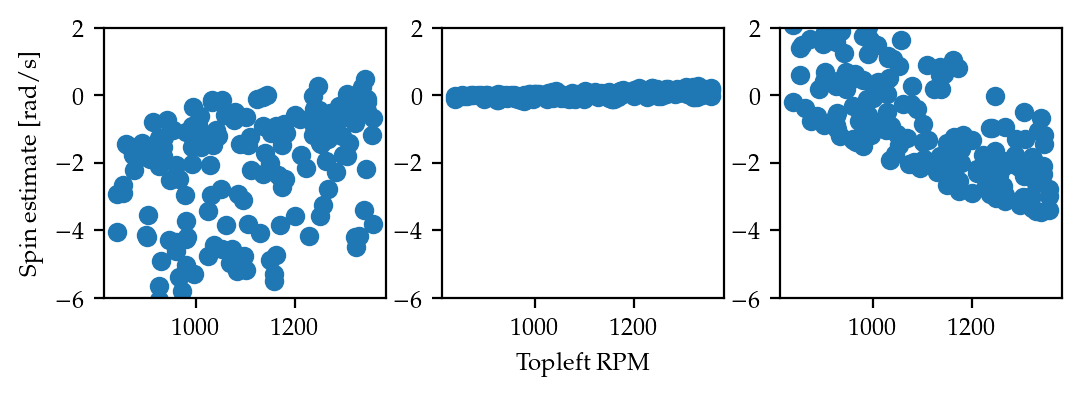

In [4]:
# x,y,z spin depending on RPM of topleft motor
fig, ax_arr = plt.subplots(nrows=1, ncols=3, figsize=(MplUtils.get_width(), 1.75))
ax_arr[0].scatter(motor_rpm[:, 0], W_nn[:, 0])
ax_arr[1].scatter(motor_rpm[:, 0], W_nn[:, 1])
ax_arr[2].scatter(motor_rpm[:, 0], W_nn[:, 2])
ax_arr[1].set_xlabel("Topleft RPM")
ax_arr[0].set_ylabel("Spin estimate [rad/s]")
for ax in ax_arr:
    ax.set_ylim(-6, 2)

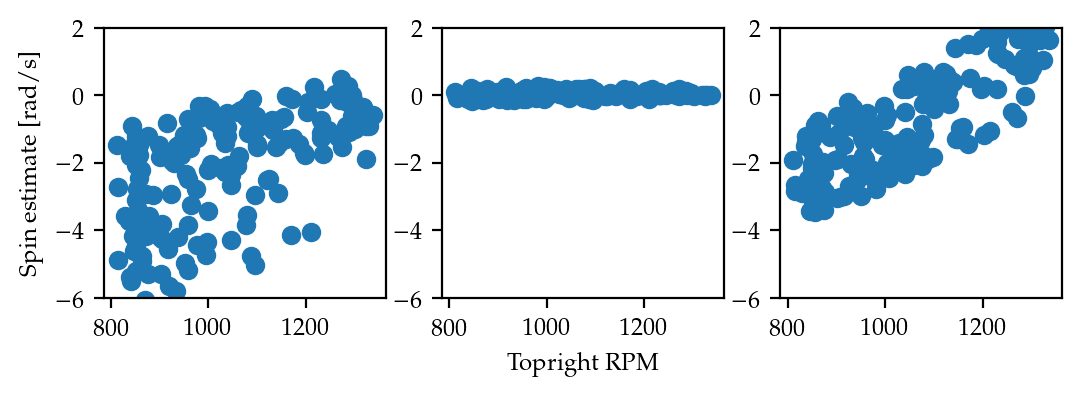

In [5]:
# x,y,z spin depending on RPM of topright motor
fig, ax_arr = plt.subplots(nrows=1, ncols=3, figsize=(MplUtils.get_width(), 1.75))
ax_arr[0].scatter(motor_rpm[:, 1], W_nn[:, 0])
ax_arr[1].scatter(motor_rpm[:, 1], W_nn[:, 1])
ax_arr[2].scatter(motor_rpm[:, 1], W_nn[:, 2])
ax_arr[1].set_xlabel("Topright RPM")
ax_arr[0].set_ylabel("Spin estimate [rad/s]")
for ax in ax_arr:
    ax.set_ylim(-6, 2)

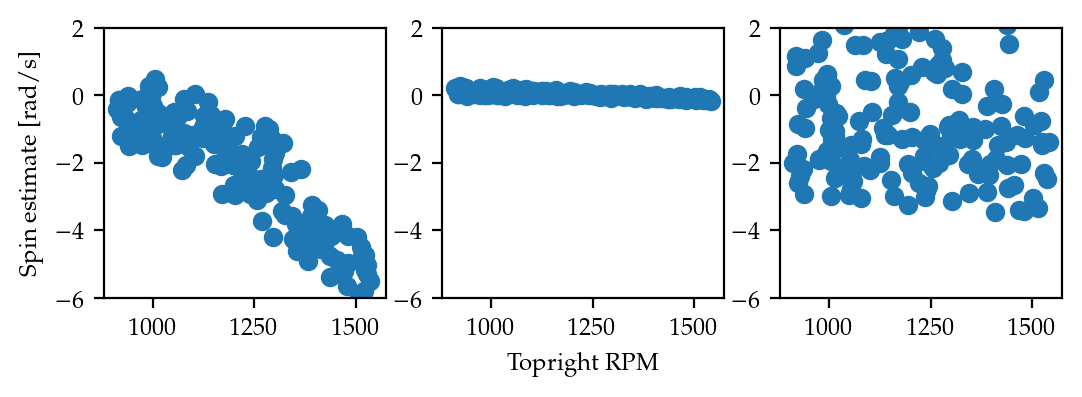

In [6]:
# x,y,z spin depending on RPM of bottom motor
fig, ax_arr = plt.subplots(nrows=1, ncols=3, figsize=(MplUtils.get_width(), 1.75))
ax_arr[0].scatter(motor_rpm[:, 2], W_nn[:, 0])
ax_arr[1].scatter(motor_rpm[:, 2], W_nn[:, 1])
ax_arr[2].scatter(motor_rpm[:, 2], W_nn[:, 2])
ax_arr[1].set_xlabel("Topright RPM")
ax_arr[0].set_ylabel("Spin estimate [rad/s]")
for ax in ax_arr:
    ax.set_ylim(-6, 2)

In [7]:
# Fit physical model (factors) to estimated spins
import math
from torch import nn
from torch import optim

class SpinModel(nn.Module):
    def __init__(self):
        super(SpinModel, self).__init__()
        self.alpha = nn.Parameter(torch.ones(1))
        self.tl_spin = nn.Parameter(torch.Tensor(np.array([1/2, 0, -math.sqrt(3)/2])), requires_grad=False)
        self.beta = nn.Parameter(torch.ones(1))
        self.tr_spin = nn.Parameter(torch.Tensor(np.array([1/2, 0, math.sqrt(3)/2])), requires_grad=False)
        self.gamma = nn.Parameter(torch.ones(1))
        self.bc_spin = nn.Parameter(torch.Tensor(np.array([-1, 0, 0])), requires_grad=False)
        
    def forward(self, motor_rpm):
        spin = (
            motor_rpm[:, 0][:, None] * self.alpha * self.tl_spin[None, :] + 
            motor_rpm[:, 1][:, None] * self.beta * self.tr_spin[None, :] + 
            motor_rpm[:, 2][:, None] * self.gamma * self.bc_spin[None, :]
        )
        return spin
    
spin_model = SpinModel()
optimizer = optim.Adam(spin_model.parameters())
for step in range(10_000):
    loss = torch.mean((spin_model(motor_rpm) - W_nn)**2)
    if step % 1000 == 0:
        print(step, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 36175.42864641835
1000 4323.133124965417
2000 98.00289041945786
3000 0.1837554389777776
4000 0.06937693007656347
5000 0.0693760138233928
6000 0.06937601380419388
7000 0.0693760137962099
8000 0.06937601379526975
9000 0.06944843650798836


In [8]:
# Print estimated factors
print(spin_model.alpha, spin_model.beta, spin_model.gamma)

Parameter containing:
tensor([0.0071], requires_grad=True) Parameter containing:
tensor([0.0066], requires_grad=True) Parameter containing:
tensor([0.0079], requires_grad=True)


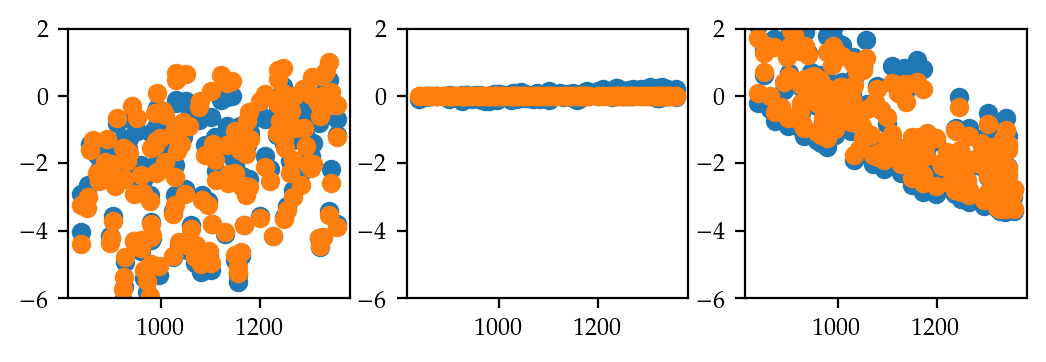

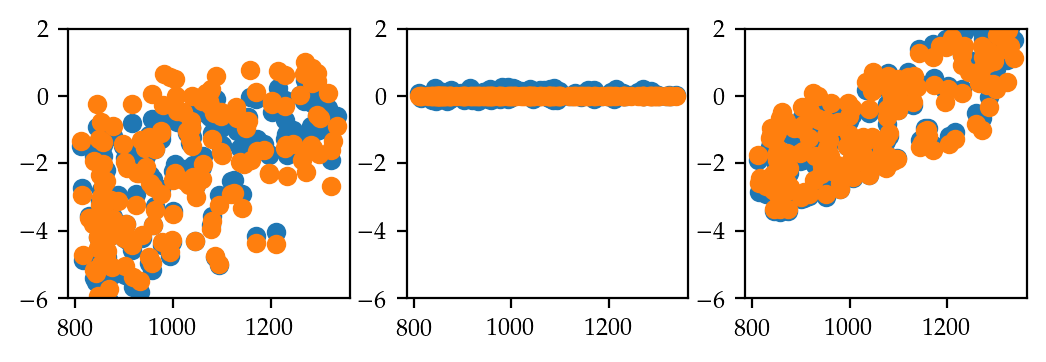

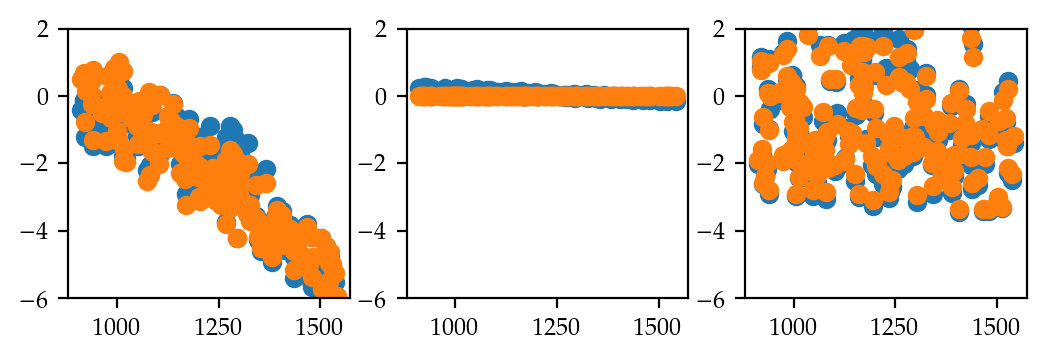

In [9]:
# Overlay estimated spins to actual spins
W_model = spin_model(motor_rpm).detach()
# topleft, topright, bottom
for motor_idx in range(3):
    fig, ax_arr = plt.subplots(nrows=1, ncols=3, figsize=(MplUtils.get_width(), 1.75))
    ax_arr[0].scatter(motor_rpm[:, motor_idx], W_nn[:, 0])
    ax_arr[1].scatter(motor_rpm[:, motor_idx], W_nn[:, 1])
    ax_arr[2].scatter(motor_rpm[:, motor_idx], W_nn[:, 2])
    ax_arr[0].scatter(motor_rpm[:, motor_idx], W_model[:, 0])
    ax_arr[1].scatter(motor_rpm[:, motor_idx], W_model[:, 1])
    ax_arr[2].scatter(motor_rpm[:, motor_idx], W_model[:, 2])
    for ax in ax_arr:
        ax.set_ylim(-6, 2)

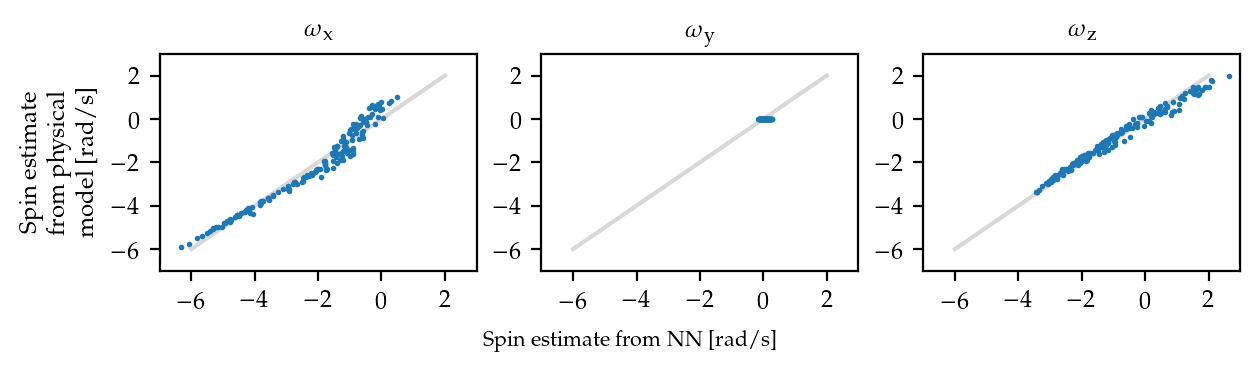

In [10]:
# Plot spin correlation
fig, ax_arr = plt.subplots(
    nrows=1,
    ncols=3,
    constrained_layout=True,
    figsize=(MplUtils.get_width(), 1.75),
)
ax_arr[0].scatter(W_nn[:, 0], W_model[:, 0], s=1)
ax_arr[0].set_title("$\omega_{\mathrm{x}}$")
ax_arr[1].scatter(W_nn[:, 1], W_model[:, 1], s=1)
ax_arr[1].set_title("$\omega_{\mathrm{y}}$")
ax_arr[2].scatter(W_nn[:, 2], W_model[:, 2], s=1)
ax_arr[2].set_title("$\omega_{\mathrm{z}}$")
for ax_idx, ax in enumerate(ax_arr):
    ax.plot(
        np.linspace(-6, 2, 50),
        np.linspace(-6, 2, 50),
        color="gray",
        zorder=-10,
        alpha=0.3,
    )
    ax.set_xticks([-6, -4, -2, 0, 2])
    ax.set_yticks([-6, -4, -2, 0, 2])
    if ax_idx == 0:
        ax.set_ylabel("Spin estimate\n from physical \n model [rad/s]")
    ax.set_xlim(-7, 3)
    ax.set_ylim(-7, 3)
fig.supxlabel("Spin estimate from NN [rad/s]", fontsize=8)
plt.savefig(
    f"graphics/spin_evaluation_correlation.png", bbox_inches="tight", pad_inches=0
)